In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 
# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model
from keras.applications.vgg16 import preprocess_input 

# clustering and dimension reduction
from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload
from src.dataLoader import dataLoader
from src.utils import image_utils, ismember

from src.preprocessing import imadjust,imagecrop,imagePaddingByShape


In [2]:
# dataset = dataLoader("../dataset")

# fileNameList = [str(imgIdx)+".jpg" for imgIdx in range(0,1501)]
# imageFileList = dataset.LoadFileList(fileNameList=fileNameList)
# imageFileList

In [3]:
from os import listdir, rename
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from collections import Counter
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise

In [4]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
labels = pd.read_csv('labels.csv')
display(labels.head())
labels.shape

,filename,label
0,0.jpg,1
1,1.jpg,1
2,2.jpg,5
3,3.jpg,4
4,4.jpg,1


(1501, 2)

In [6]:
def load_images(labels):
    X = []
    y = []
    for row in labels.itertuples():
        img_path = join('../dataset', row.filename)
        # print(row.filename)
        # print(img_path)
        # img = np.asarray(Image.open(img_path))
        # img = np.array(img) 
        img = load_img(img_path, target_size=(50,50))
        img = np.asarray(img)
        # Keep squares for now
        if img.shape[0] == img.shape[1]:
            y.append(row.label)
            X.append(img)
    return X, y

# def load_images(labels, number_image=1000):
#     X = []
#     y = []
#     for row in labels.itertuples():
#         img_path = join('../dataset', row.filename)
#         # print(row.filename)
#         # print(img_path)
#         img = np.asarray(Image.open(img_path))
#         # Keep squares for now
#         if img.shape[0] == img.shape[1]:
#           img = load_img(img_path, target_size=(50,50))
#           img = np.asarray(img)
#           y.append(row.label)
#           X.append(img)
#         elif len(X) <= number_image:
#           img = load_img(img_path, target_size=(50,50))
#           img = np.asarray(img)
#           y.append(row.label)
#           X.append(img)
#     return X, y

In [7]:
# def augment_data(X_train, y_train):
#     final_X_train = []
#     final_y_train = []
#     label_distribution = Counter(y_train)
#     print(label_distribution)
#     for i in range(len(X_train)):
#         final_X_train.append(X_train[i])
#         final_X_train.append(rotate(X_train[i], angle=45, mode = 'wrap'))
#         final_X_train.append(np.fliplr(X_train[i]))
#         final_X_train.append(np.flipud(X_train[i]))
#         final_X_train.append(random_noise(X_train[i],var=0.2**2))
        
#         final_y_train += [y_train[i]] * 5
#     print(label_distribution)
#     return final_X_train, final_y_train

def augment_data(X_train, y_train):
    final_X_train = []
    final_y_train = []
    label_distribution = Counter(y_train)
    print(label_distribution)
    max_count_label = max(label_distribution, key=label_distribution.get)
    min_count_label = min(label_distribution, key=label_distribution.get)
    for i in range(len(X_train)):
        label_key = y_train[i]
        if label_distribution[max_count_label] - label_distribution[label_key] >= 10 or label_distribution[max_count_label] - label_distribution[min_count_label] <= 6:
            final_X_train.append(X_train[i])
            final_X_train.append(rotate(X_train[i], angle=45, mode = 'wrap'))
            final_X_train.append(np.fliplr(X_train[i]))
            final_X_train.append(np.flipud(X_train[i]))
            final_X_train.append(random_noise(X_train[i],var=0.2**2))
        
            final_y_train += [y_train[i]] * 5
            label_distribution = Counter(final_y_train)
            max_count = max(label_distribution, key=label_distribution.get)
            min_count = min(label_distribution, key=label_distribution.get)
    print(label_distribution)
    return final_X_train, final_y_train

In [8]:
def get_accuracy(scores, labels):
    num_data = scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches = indicator.sum()
    return 100*num_matches.float()/num_data  

def get_error( scores , labels ):

    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    
    return 1-num_matches.float()/bs   

def eval_on_test_set(test_data, test_label, net, mean, std, bs):

    running_error=0
    running_acc = 0
    num_batches=0

    for i in range(0,100,bs):

        minibatch_data =  test_data[i:i+bs].to(device)
        minibatch_label = test_label[i:i+bs].to(device)
        
        inputs = (minibatch_data - mean)/std

        scores= net( inputs ) 

        error = get_error( scores.detach() , minibatch_label)
        acc = get_accuracy( scores.detach() , minibatch_label)

        running_error += error.item()
        running_acc += acc.item()

        num_batches+=1

    total_error = running_error/num_batches
    total_acc = running_acc/num_batches
    print(running_error, num_batches)
    print( 'error rate on test set =', total_error*100 ,'percent')
    print('accuracy =', total_acc)

In [9]:
X, y = load_images(labels)
np.array(X).shape

(1501, 50, 50, 3)

In [10]:
# label_distribution = Counter(y)
# print(label_distribution.values())
# max(label_distribution, key=label_distribution.get)
# min(label_distribution, key=label_distribution.get)
# label_distribution[1]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2, stratify=y)

In [12]:
X_train, y_train = augment_data(X_train, y_train)
np.array(X_train).shape

Counter({1: 355, 0: 314, 2: 202, 5: 148, 3: 95, 4: 86})
Counter({1: 440, 0: 435, 2: 435, 4: 430, 3: 405, 5: 405})


(2550, 50, 50, 3)

In [13]:
# X_train, y_train = augment_data(X_train, y_train)
# np.array(X_train).shape

In [14]:
# import torch
# class convnet(torch.nn.Module):

#     def __init__(self, input_channel, hidden_layer, num_class):

#         super(convnet, self).__init__()
      
#         self.conv1a = torch.nn.Conv2d(input_channel, hidden_layer,  kernel_size=5, padding=1 )
#         self.pool1a  = torch.nn.MaxPool2d(2,2)
#         self.conv1b = torch.nn.Conv2d(hidden_layer,  hidden_layer,  kernel_size=5, padding=1 )
#         self.pool1b  = torch.nn.MaxPool2d(2,2)
        
#         self.linear1 = torch.nn.Linear(12100, num_class)

#     def forward(self, x):
#         x = self.conv1a(x)
#         x = torch.nn.functional.relu(x)
#         x = self.pool1a(x)
#         x = self.conv1b(x)
#         x = torch.nn.functional.relu(x)
#         x = self.pool1b(x)
        
#         x = x.view(-1, 12100)
#         x = self.linear1(x)
        
#         return x

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from random import randint
import utils
import time

class VGG_convnet(nn.Module):

    def __init__(self, input_channel, num_class):

        super(VGG_convnet, self).__init__()

        # block 1:         3 x 50 x 50 --> 64 x 25 x 25        
        self.conv1a = nn.Conv2d(3,   64,  kernel_size=3, padding=1 )
        self.conv1b = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        self.pool1  = nn.MaxPool2d(2,2)

        # block 2:         64 x 25 x 25 --> 128 x 8 x 8
        self.conv2a = nn.Conv2d(64,  128, kernel_size=3, padding=1 )
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1 )
        self.pool2  = nn.MaxPool2d(2,2)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4        
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1 )
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1 )
        self.pool3  = nn.MaxPool2d(2,2)
        
        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1 )
        self.pool4  = nn.MaxPool2d(2,2)

        # linear layers:   512 x 2 x 2 --> 4608 --> 4096 --> 4096 --> 10
        self.linear1 = nn.Linear(4608, 4608*2)
        self.linear2 = nn.Linear(4608*2,4096)
        self.linear3 = nn.Linear(4096, num_class)

    def rgb2hsv(self, input, epsilon=1e-10):
        assert(input.shape[1] == 3)
        r, g, b = input[:, 0], input[:, 1], input[:, 2]
        max_rgb, argmax_rgb = input.max(1)
        min_rgb, argmin_rgb = input.min(1)
        max_min = max_rgb - min_rgb + epsilon
        h1 = 60.0 * (g - r) / max_min + 60.0
        h2 = 60.0 * (b - g) / max_min + 180.0
        h3 = 60.0 * (r - b) / max_min + 300.0
        h = torch.stack((h2, h3, h1), dim=0).gather(dim=0, index=argmin_rgb.unsqueeze(0)).squeeze(0)
        s = max_min / (max_rgb + epsilon)
        v = max_rgb
        return torch.stack((h, s, v), dim=1)

    def forward(self, x):
        # print(x.shape)
        x = self.rgb2hsv(x)
        # block 1:         3 x 32 x 32 --> 64 x 16 x 16
        x = self.conv1a(x)
        x = torch.relu(x)
        x = self.conv1b(x)
        x = torch.relu(x)
        x = self.pool1(x)

        # block 2:         64 x 16 x 16 --> 128 x 8 x 8
        x = self.conv2a(x)
        x = torch.relu(x)
        x = self.conv2b(x)
        x = torch.relu(x)
        x = self.pool2(x)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4
        x = self.conv3a(x)
        x = torch.relu(x)
        x = self.conv3b(x)
        x = torch.relu(x)
        x = self.pool3(x)

        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        x = self.conv4a(x)
        x = torch.relu(x)
        x = self.pool4(x)

        # linear layers:   512 x 2 x 2 --> 4608 --> 4608*2 --> 4096 --> 10
        # print(x.shape)
        x = x.view(-1, 4608)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x) 
        
        return x

In [16]:
# def eval_on_test_set(X_test):

#     running_error=0
#     running_acc = 0
#     num_batches=0

#     for i in range(0,100,bs):

#         minibatch_data =  X_test[i:i+bs]
#         minibatch_label = y_test[i:i+bs]

#         minibatch_data=minibatch_data.to(device)
#         minibatch_label=minibatch_label.to(device)
        
#         inputs = (minibatch_data - mean)/std

#         scores= net( inputs ) 

#         error = get_error( scores.detach() , minibatch_label)
#         acc = get_accuracy( scores.detach() , minibatch_label)

#         running_error += error.item()
#         running_acc += acc.item()

#         num_batches+=1

#     total_error = running_error/num_batches
#     total_acc = running_acc/num_batches
#     print(running_error, num_batches)
#     print( 'error rate on test set =', total_error*100 ,'percent')
#     print('accuracy =', total_acc)

In [17]:
def train_network(X_train, y_train, X_test, y_test, net, mean, std):
    
    X_train = X_train.view(-1, 3, 50, 50)
    X_test = X_test.view(-1, 3, 50, 50)
    num_train_data = X_train.size()[0]
    my_lr = 0.001
    criterion = torch.nn.CrossEntropyLoss()
    
    for epoch in range(100):
        # create a new optimizer at the beginning of each epoch: give the current learning rate.   
        optimizer=torch.optim.Adam( net.parameters() , lr=my_lr )

        # set the running quatities to zero at the beginning of the epoch
        running_loss=0
        running_error=0
        running_acc = 0
        num_batches=0

        # set the order in which to visit the image from the training set
        shuffled_indices = torch.randperm(num_train_data)

        for count in range(0,num_train_data,bs):

            # Set the gradients to zeros
            optimizer.zero_grad()

            # create a minibatch       
            indices = shuffled_indices[count:count+bs].to(device)
            minibatch_data =  X_train[indices].to(device)
            minibatch_label =  y_train[indices].to(device)


            # normalize the minibatch (this is the only difference compared to before!)
            inputs = (minibatch_data - mean)/std

            # tell Pytorch to start tracking all operations that will be done on "inputs"
            inputs.requires_grad_()

            # forward the minibatch through the net 
            scores=net( inputs ) 

            # Compute the average of the losses of the data points in the minibatch
            loss =  criterion( scores , minibatch_label) 

            # backward pass to compute dL/dU, dL/dV and dL/dW   
            loss.backward()

            # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
            optimizer.step()


            # START COMPUTING STATS

            # add the loss of this batch to the running loss
            running_loss += loss.detach().item()

            # compute the error made on this batch and add it to the running error       
            error = get_error( scores.detach() , minibatch_label)
            acc = get_accuracy(scores.detach() , minibatch_label)
            running_error += error.item()
            running_acc += acc.item()

            num_batches+=1        


        # compute stats for the full training set
        total_loss = running_loss/num_batches
        total_error = running_error/num_batches
        total_acc = running_acc/num_batches


        print('epoch=',epoch, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        print('accuracy =', total_acc)
        print(' ')

    eval_on_test_set(X_test, y_test, net, mean, std, bs)

In [18]:
num_class = 6
bs = 64
X_train = torch.from_numpy(np.array(X_train).astype(np.float32))
y_train = torch.from_numpy(np.array(y_train).astype(np.float32)).type(torch.LongTensor)
X_test = torch.from_numpy(np.array(X_test).astype(np.float32))
y_test = torch.from_numpy(np.array(y_test).astype(np.float32)).type(torch.LongTensor)

net = VGG_convnet(3, num_class).to(device)
mean = X_train.mean().to(device)
std = X_train.std().to(device)


train_network(X_train, y_train, X_test, y_test, net, mean, std)

D:\Anaconda3\envs\deeplearn_course\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch= 0 	 loss= 3.266898065805435 	 error= 83.7239582836628 percent
accuracy = 16.276041650772093
 
epoch= 1 	 loss= 1.793941080570221 	 error= 83.89467597007751 percent
accuracy = 16.105324077606202
 
epoch= 2 	 loss= 1.7993314683437347 	 error= 82.74016201496124 percent
accuracy = 17.2598379611969
 
epoch= 3 	 loss= 1.7923762172460556 	 error= 82.03993052244186 percent
accuracy = 17.960069465637208
 
epoch= 4 	 loss= 1.7869597285985948 	 error= 81.06047451496124 percent
accuracy = 18.9395254611969
 
epoch= 5 	 loss= 1.7440718680620193 	 error= 78.15538197755814 percent
accuracy = 21.84461808204651
 
epoch= 6 	 loss= 1.7257761389017106 	 error= 76.58564805984497 percent
accuracy = 23.414351844787596
 
epoch= 7 	 loss= 1.7277139484882356 	 error= 75.66550925374031 percent
accuracy = 24.334490728378295
 
epoch= 8 	 loss= 1.7238193809986115 	 error= 75.26041656732559 percent
accuracy = 24.73958330154419
 
epoch= 9 	 loss= 1.724526399374008 	 error= 75.08391201496124 percent
accuracy = 2

In [19]:
labels.head()

,filename,label
0,0.jpg,1
1,1.jpg,1
2,2.jpg,5
3,3.jpg,4
4,4.jpg,1


In [20]:
def modify_label(df, image_idx, label):
    file_name = str(image_idx)+".jpg"
    display(df.loc[df["filename"]==file_name])
    df.loc[df["filename"]==file_name, "label"] = label
    display(df.loc[df["filename"]==file_name])

In [21]:
""" Dont run this unless you comfirm to modify label
"""
modify = False
if modify:
    modify_label(labels, idx, 2)

In [22]:
# labels.to_csv("label.csv")

197


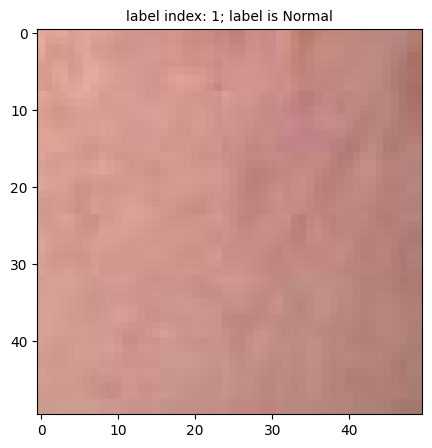

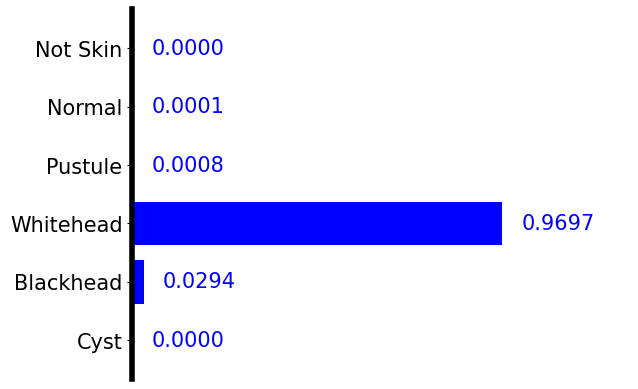

In [30]:
# choose a picture at random
idx=randint(0, 1500*0.2)
label = ('Not Skin', 'Normal', 'Pustule', 'Whitehead', 'Blackhead', 'Cyst',)

print(idx)
im=X_test[idx].cpu().detach().numpy().astype(np.uint8)
# X_train, X_test, y_train, y_test
# diplay the picture
image_label = f"label index: {y_test[idx]}; label is {label[y_test[idx]]}"
image_utils().plot_image(im,title=image_label, figsize=(5,5))

im=X_test[idx]
im = torch.from_numpy(np.array(im).astype(np.float32)).to(device)
X_train_ = torch.from_numpy(np.array(X_train).astype(np.float32))
X_train_ = X_train_.view(-1, 3, 50, 50)
mean= X_train_.mean()
std= X_train_.std()
# # send to device, rescale, and view as a batch of 1 
# im = im.to(device)
im= (im-mean) / std

im=im.view(1,3,50,50)

# # feed it to the net and display the confidence scores
scores =  net(im) 
probs= torch.softmax(scores, dim=1)
image_utils().show_prob_pimples(probs.cpu())

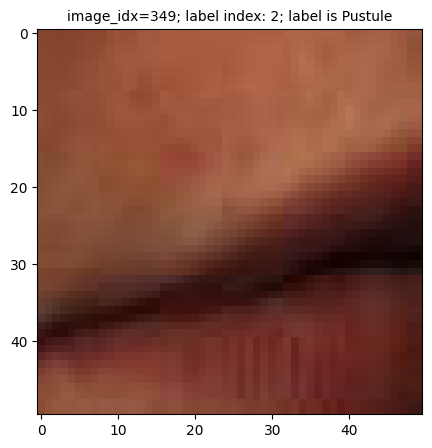

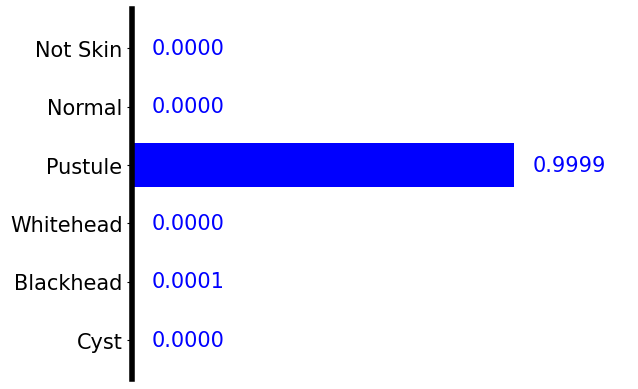

In [24]:
# choose a picture at random
idx=randint(0, 1500)
label = ('Not Skin', 'Normal', 'Pustule', 'Whitehead', 'Blackhead', 'Cyst',)

im=X[idx]
# X_train, X_test, y_train, y_test
# diplay the picture
image_label = f"image_idx={idx}; label index: {y[idx]}; label is {label[y[idx]]}"
image_utils().plot_image(im,title=image_label, figsize=(5,5))

im=X[idx]
im = torch.from_numpy(np.array(im).astype(np.float32)).to(device)
X_train_ = torch.from_numpy(np.array(X_train).astype(np.float32))
X_train_ = X_train_.view(-1, 3, 50, 50)
mean= X_train_.mean()
std= X_train_.std()
# # send to device, rescale, and view as a batch of 1 
# im = im.to(device)
im= (im-mean) / std

im=im.view(1,3,50,50)

# # feed it to the net and display the confidence scores
scores =  net(im) 
probs= torch.softmax(scores, dim=1)
image_utils().show_prob_pimples(probs.cpu())